## Plotting packages

In [7]:
using Interact
using PyPlot
#PyPlot.svg(true)

INFO: Loading help data...


## Instanton analysis

In [1]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton3.jl")

using TemporalInstanton3
using HDF5, JLD

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
#P0 = [0.5.*Rp,Rp,1.5*Rp]
P0 = [Rp,Rp,Rp]
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

println("loaded")

score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,Tamb,
    T0,int_length)
println("Unsolved lines: $(sum(score.==Inf))")

loaded
Unsolved lines: 0


## Functions for finding power flow based on fixed decision variables

In [4]:
# Expand renewable generation vector with zeros:
function expand_renewable_vector(x,Ridx,N,T)
    idx = Array(Integer,0)
    for i = 0:T-1
        append!(idx,Ridx + i*N)
    end
    P = zeros(N*T)
    P[idx] = x
    return P
end

function fixed_wind_A(T,Y,ref,k)
    """ Generate the power balance constraint A matrix
    from problem dimensions, admittance matrix,
    and generator participation factors.
    Assumes the admittance matrix is n-by-n.
    
    Returns A, which is (n+1)*T-by-(nr+n+1)*T
    
    * nr is the number of wind farms in the network
    * n is the number of nodes in the network
    * Ridx is a vector indicating wind farm locations
    * T is the number of time steps
    * Y is the admittance matrix (n-by-n)
    * ref is the index of the angle reference bus
    * k is the vector of generator participation factors
    """
    
    function ei(n,i)
        e = zeros(n)
        e[i] = 1.
        return e
    end
    
    n = size(Y,1)
    
    # A has a block diagonal pattern where each
    # block is Atemp:
    Atemp = sparse([[  Y       -k];
                    ei(n,ref)'   0])
    
    # Now we can tile the Atemp matrix to generate A:
    A = Atemp
    for t = 2:T
        A = blkdiag(A, Atemp)
    end
    
    return full(A)
end

function fixed_wind_b(n,T,G0,Pnet,D)
    """ Generate the vector b of power balance constraints.
    Assumes G0 and D are nT-by-1 vectors.
    """
    b = FloatingPoint[]
    netGen = G0 + Pnet - D

    for t = 1:T
        start = (t-1)*n + 1
        stop = start + n - 1
        append!(b,netGen[start:stop])
        push!(b,0.)
    end
    return b
end

function return_angles(fixed_x,N)
    angles = Array(Vector,0)
    alpha = FloatingPoint[]
    for i = 1:T
        push!(angles,fixed_x[(N+1)*(i-1)+1:(N+1)*(i-1)+N])
        push!(alpha,fixed_x[(N+1)*(i-1)+N+1])
    end
    return angles,alpha
end

function return_angle_diffs(angles,line)
    angle_diffs = FloatingPoint[]
    f = line[1]
    t = line[2]
    for v in angles
        push!(angle_diffs,v[f] - v[t])
    end
    return angle_diffs
end

return_angle_diffs (generic function with 1 method)

## Plot overlay of instanton with other vectors (perturbed/higher objective)

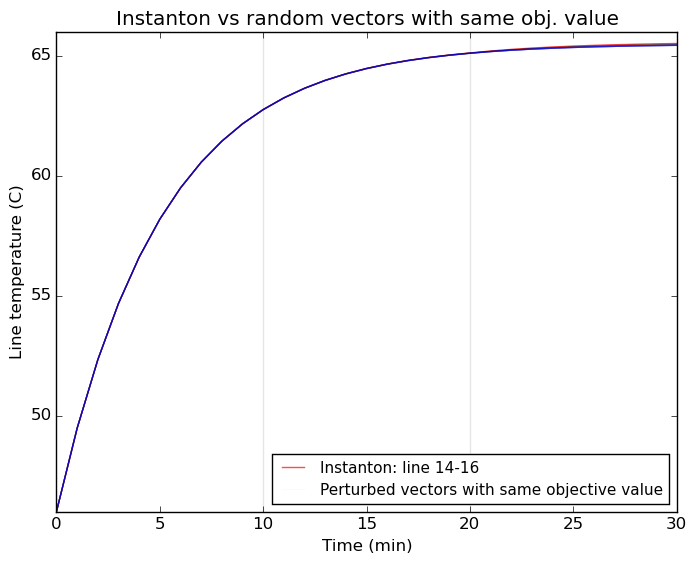

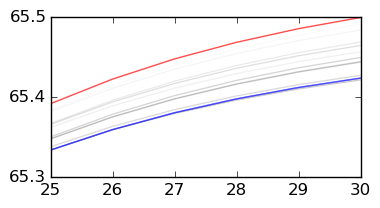

3-element Array{Int64,1}:
  5
 15
 25

In [40]:
eidx = 1

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10

vecs = Array(Vector,0)

# First vector is instanton analysis output:
push!(vecs,[x[idx][1],x[idx][2],x[idx][3]])
#push!(vecs,zeros(54))

for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*i/500
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end
# Now vecs contains a family of vectors with the same
# norm.

# Next, add vectors whose objective value is smaller.
# These vectors will be even further from the instanton.
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5)/500
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = zeros(size(vecs[1],1))#(sqrt(score[idx])/(i/2+1))*inter/norm(inter)
    push!(vecs,traj)
end

angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)

fig = figure(figsize=(8,6))

temp_trajectories = Array(Vector,0)

for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7,"r")
        elseif i <= numVecs + 1
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"k")
    else
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"b")
    end
end
title("Instanton vs random vectors with same obj. value")
#xlabel("Time (min)")
ylabel("Line temperature (C)")
xlabel("Time (min)")
legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([0,30,46,66])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
midpoints = [5,15,25]

#savefig("../images/2015-06-18-inst-vs-rand.svg")

fig2 = figure(figsize=(4,2))
# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7,"r")
        elseif i <= numVecs + 1
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"k")
    else
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"b")
    end
end
#title("Instanton candidate vs random vectors with same obj. value")
#xlabel("Time (min)")
#ylabel("Line temperature (C)")
#legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([25,30,65.3,65.5])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
yticks(65.3:0.1:65.5)
midpoints = [5,15,25]

#savefig("../images/2015-06-18-inst-vs-rand-zoom.svg")


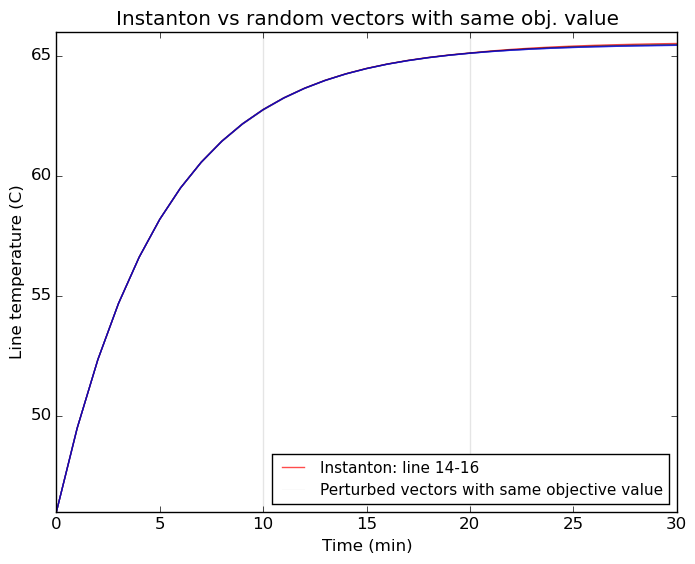

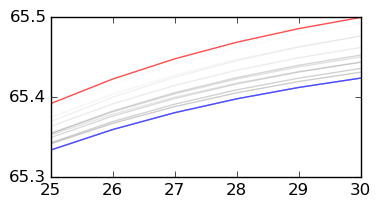

3-element Array{Int64,1}:
  5
 15
 25

In [10]:
eidx = 1

T = 3
n = size(Y,1)

# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10

vecs = Array(Vector,0)

# First vector is instanton analysis output:
push!(vecs,[x[idx][1],x[idx][2],x[idx][3]])
#push!(vecs,zeros(54))

for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*i/500
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end
# Now vecs contains a family of vectors with the same
# norm.

# Next, add vectors whose objective value is smaller.
# These vectors will be even further from the instanton.
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5)/500
    #inter = zeros(size(vecs[1]))#rand(Nr*T) - 0.5
    # Normalize to match min-score objective:
    traj = zeros(size(vecs[1],1))#(sqrt(score[idx])/(i/2+1))*inter/norm(inter)
    push!(vecs,traj)
end

angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)

fig = figure(figsize=(8,6))

temp_trajectories = Array(Vector,0)

for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7,"r")
        elseif i <= numVecs + 1
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"k")
    else
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"b")
    end
end
title("Instanton vs random vectors with same obj. value")
#xlabel("Time (min)")
ylabel("Line temperature (C)")
xlabel("Time (min)")
legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([0,30,46,66])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
midpoints = [5,15,25]

#savefig("../images/2015-06-18-inst-vs-rand.svg")

fig2 = figure(figsize=(4,2))
# Plot
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(temp_trajectories[i],alpha=0.7,"r")
        elseif i <= numVecs + 1
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"k")
    else
        plot(temp_trajectories[i],alpha=(mod(i-2,numVecs)+1)/50,"b")
    end
end
#title("Instanton candidate vs random vectors with same obj. value")
#xlabel("Time (min)")
#ylabel("Line temperature (C)")
#legend(["Instanton: line $(from)-$(to)","Perturbed vectors with same objective value"],fontsize=11,loc=4)
# axis([0,30,40,1.1*Tlim])
axis([25,30,65.3,65.5])
plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
yticks(65.3:0.1:65.5)
midpoints = [5,15,25]

#savefig("../images/2015-06-18-inst-vs-rand-zoom.svg")


## New idea: find each line's steady-state temperature assuming forecast is accurate

If any line is able to reach its temperature limit without deviation from forecast, we cannot perform instanton analysis. If we do, the result will be a wind pattern that causes an overall _reduction_ in temperature with respect to the steady-state temperature. The forecast (dispatch) must be altered until no line reaches its temperature limit.

Also, each instanton analysis run should have a steady-state temperature to begin with, based on the power flow across each line. This is something Mads does in his work. Currently, my analysis assumes all lines start at the same temperature, which is not realistic.

In [83]:
# Thermal parameters:
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.5
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Test vector represents no deviation from forecast:
testVec = zeros(Nr*T)

steady_angles = Array(Vector,0)
steady_diffs = Array(Vector,0)
temp_trajectories = Array(Vector,0)

for idx = 1:size(lines[line_lengths.!=0],1)
    # Line parameters:
    line = lines[line_lengths.!=0][idx]
    from,to = line
    r_ij = res[line_lengths.!=0][idx]
    x_ij = reac[line_lengths.!=0][idx]
    L_ij = line_lengths[line_lengths.!=0][idx]
    
    fixed_wind = testVec
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N)
    push!(steady_angles,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(steady_diffs,fixed_diffs)
    
    T0 = 46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end

    push!(temp_trajectories,temp_values)
end

In [82]:
[lines[line_lengths.!=0][idx] for idx in 1:size(lines[line_lengths.!=0],1)]

104-element Array{Any,1}:
 (1,2)  
 (1,3)  
 (1,5)  
 (2,4)  
 (2,6)  
 (3,9)  
 (4,9)  
 (5,10) 
 (6,10) 
 (7,8)  
 (7,27) 
 (8,9)  
 (8,10) 
 ⋮      
 (64,67)
 (65,66)
 (65,70)
 (66,69)
 (66,69)
 (67,68)
 (67,68)
 (68,71)
 (68,71)
 (69,70)
 (73,21)
 (66,47)

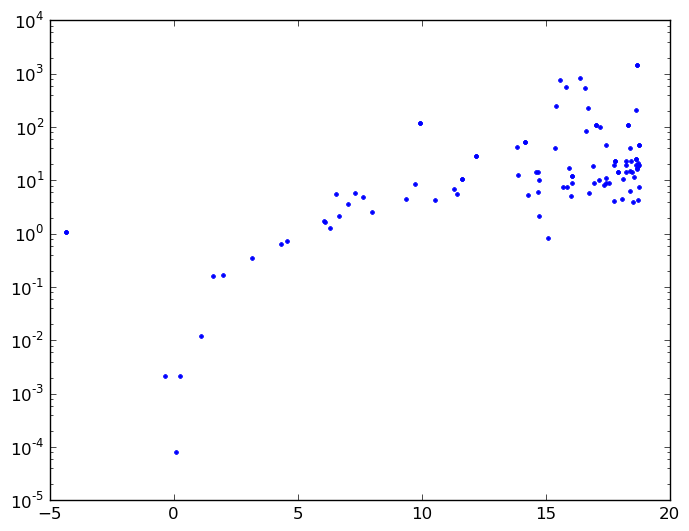

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3731fe8a50>

In [105]:
semilogy(65.5 - [v[end] for v in temp_trajectories],score,linewidth=0,marker=".")
#PyPlot.yscale("log")

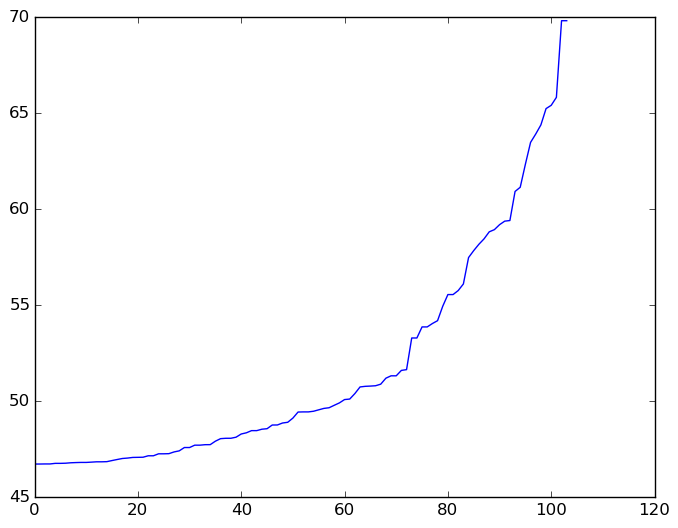

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3731df6ad0>

In [84]:
plot(sort([v[end] for v in temp_trajectories]))